In [ ]:
# Pastikan untuk menjalankan cell ini di awal untuk menginstal dependensi yang diperlukan
!pip install pytesseract
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,229 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step - accuracy: 0.7405 - loss: 0.1000 - val_accuracy: 1.0000 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0368 - val_accuracy: 1.0000 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 1.0000 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 1.0000 - va

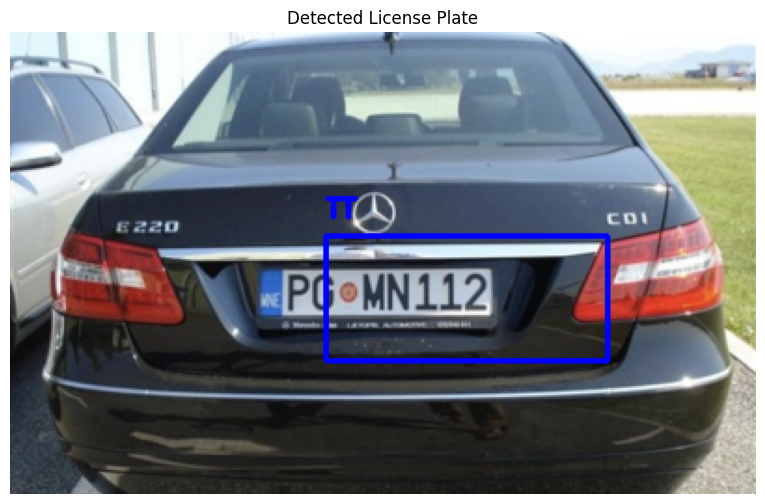

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pytesseract
import xml.etree.ElementTree as ET
from pathlib import Path
import logging
import sys

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('license_plate_detection.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

# Constants
IMAGE_SIZE = 224  # Changed to match MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 50
VALID_IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png'}
PLATE_KEYWORDS = ['plate', 'license', 'number', 'lp', 'licence', 'vehicle', 'car']

def extract_dataset(zip_file_path, extract_dir):
    """Safely extract dataset and verify contents"""
    try:
        # Verify zip file exists
        if not os.path.exists(zip_file_path):
            raise FileNotFoundError(f"Zip file not found at: {zip_file_path}")

        os.makedirs(extract_dir, exist_ok=True)

        logging.info(f"Extracting dataset from {zip_file_path} to {extract_dir}")

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # List contents before extraction
            contents = zip_ref.namelist()
            logging.info(f"Zip contents: {contents[:10]}...")  # Show first 10 files

            zip_ref.extractall(extract_dir)

        # Verify extraction
        extracted_files = os.listdir(extract_dir)
        logging.info(f"Extracted contents: {extracted_files}")

        # Verify specific directories
        images_dir = os.path.join(extract_dir, 'images')
        annot_dir = os.path.join(extract_dir, 'annotations')

        if not os.path.exists(images_dir):
            raise ValueError(f"Images directory not found at: {images_dir}")
        if not os.path.exists(annot_dir):
            raise ValueError(f"Annotations directory not found at: {annot_dir}")

        logging.info(f"Dataset extracted successfully to {extract_dir}")

    except Exception as e:
        logging.error(f"Failed to extract dataset: {str(e)}")
        raise

def verify_dataset_structure(dataset_path):
    """Verify dataset has required structure and files"""
    images_path = Path(dataset_path) / 'images'
    annotations_path = Path(dataset_path) / 'annotations'

    if not images_path.exists():
        raise ValueError(f"Images directory not found at {images_path}")
    if not annotations_path.exists():
        raise ValueError(f"Annotations directory not found at {annotations_path}")

    return images_path, annotations_path

def analyze_dataset_annotations(dataset_path):
    """Analyze the XML files in the dataset to understand the annotation format"""
    annotations_path = Path(dataset_path) / 'annotations'

    logging.info(f"Looking for annotations at: {annotations_path}")
    logging.info(f"Dataset path contents: {os.listdir(dataset_path)}")

    if not annotations_path.exists():
        logging.error(f"Annotations directory not found at {annotations_path}")
        raise FileNotFoundError(f"Annotations directory not found at {annotations_path}")

    unique_labels = set()
    label_counts = {}

    xml_files = list(annotations_path.glob('*.xml'))
    logging.info(f"Found {len(xml_files)} XML files")

    if not xml_files:
        raise ValueError("No XML files found in annotations directory")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            for obj in root.findall('.//object'):
                name = obj.find('name')
                if name is not None and name.text:
                    label = name.text.lower().strip()
                    unique_labels.add(label)
                    label_counts[label] = label_counts.get(label, 0) + 1

        except Exception as e:
            logging.error(f"Error analyzing {xml_file}: {str(e)}")
            continue

    logging.info("Dataset Analysis Results:")
    logging.info(f"Unique labels found: {sorted(unique_labels)}")
    logging.info("Label counts:")
    for label, count in sorted(label_counts.items()):
        logging.info(f"  {label}: {count}")

    return unique_labels, label_counts

def preprocess_image(image_path):
    """Preprocess image with error handling"""
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        original_height, original_width = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image.astype(np.float32) / 255.0
        return image, original_width, original_height
    except Exception as e:
        logging.error(f"Error preprocessing image {image_path}: {str(e)}")
        raise

def parse_xml_annotation(xml_path, image_width, image_height):
    """Parse XML annotation file with improved label detection"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('.//object'):
            name = obj.find('name')
            if name is None:
                continue

            name_text = name.text.lower().strip()

            if any(keyword in name_text for keyword in PLATE_KEYWORDS):
                bbox = obj.find('.//bndbox')
                if bbox is None:
                    continue

                try:
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)

                    if not (0 <= xmin < xmax <= image_width and 0 <= ymin < ymax <= image_height):
                        continue

                    x_center = ((xmin + xmax) / 2) / image_width
                    y_center = ((ymin + ymax) / 2) / image_height
                    bbox_width = (xmax - xmin) / image_width
                    bbox_height = (ymax - ymin) / image_height

                    return [x_center, y_center, bbox_width, bbox_height, 1.0]

                except (AttributeError, ValueError) as e:
                    logging.debug(f"Error parsing bounding box in {xml_path}: {str(e)}")
                    continue

        return None

    except Exception as e:
        logging.error(f"Error parsing {xml_path}: {str(e)}")
        return None

def load_dataset(dataset_path):
    """Load dataset with improved validation and filtering"""
    images = []
    labels = []
    skipped_count = 0
    valid_count = 0

    images_path, annotations_path = verify_dataset_structure(dataset_path)

    logging.info(f"Loading dataset from: {images_path}")
    image_files = [f for f in os.listdir(images_path)
                  if Path(f).suffix.lower() in VALID_IMAGE_EXTENSIONS]

    if not image_files:
        raise ValueError("No valid image files found in the dataset directory")

    logging.info(f"Found {len(image_files)} images. Loading...")

    for i, img_name in enumerate(image_files, 1):
        try:
            img_path = Path(images_path) / img_name
            xml_path = Path(annotations_path) / f"{Path(img_name).stem}.xml"

            if not xml_path.exists():
                skipped_count += 1
                continue

            # Load and preprocess image
            image, orig_width, orig_height = preprocess_image(img_path)

            # Parse XML annotation
            label = parse_xml_annotation(xml_path, orig_width, orig_height)

            if label is not None:
                labels.append(label)
                images.append(image)
                valid_count += 1
            else:
                skipped_count += 1

            # Show progress
            if i % 50 == 0:
                logging.info(f"Processed {i}/{len(image_files)} images. "
                           f"Valid: {valid_count}, Skipped: {skipped_count}")

        except Exception as e:
            logging.error(f"Error processing {img_name}: {str(e)}")
            skipped_count += 1
            continue

    if not images:
        raise ValueError("No valid image-label pairs found in the dataset")

    logging.info(f"Dataset loading completed:")
    logging.info(f"  Total images processed: {len(image_files)}")
    logging.info(f"  Valid pairs found: {valid_count}")
    logging.info(f"  Skipped images: {skipped_count}")

    return np.array(images), np.array(labels)

def create_model():
    """Create and compile model with transfer learning"""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Changed to standard input size
    )

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(5, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['accuracy']
    )

    return model

def train_model(dataset_path):
    """Train model with data augmentation and monitoring"""
    try:
        # Load and analyze dataset
        unique_labels, label_counts = analyze_dataset_annotations(dataset_path)
        logging.info("Dataset analysis completed")

        # Load dataset
        X_train, y_train = load_dataset(dataset_path)

        # Create data augmentation
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomBrightness(0.2),
            tf.keras.layers.RandomContrast(0.2),
        ])

        # Create model
        model = create_model()
        logging.info("Model created successfully")

        # Setup callbacks
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                "best_model.keras",  # Changed from .h5 to .keras
                save_best_only=True,
                monitor='val_loss'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=0.00001
            ),
            tf.keras.callbacks.CSVLogger('training_log.csv')
        ]

        # Train model
        logging.info("Starting model training...")
        history = model.fit(
            data_augmentation(X_train),
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=callbacks,
            shuffle=True
        )

        logging.info("Model training completed successfully")
        return model, history

    except Exception as e:
        logging.error(f"Training failed: {str(e)}")
        raise

def plot_training_results(history):
    """Plot and save training metrics"""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.close()

def detect_license_plate(model, image_path):
    """Detect license plate in image and perform OCR"""
    try:
        # Read and preprocess image
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        height, width = original_image.shape[:2]

        # Preprocess for prediction
        image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)

        # Predict
        prediction = model.predict(image)[0]

        # Convert prediction to bounding box coordinates
        x_center, y_center, w, h, conf = prediction

        # Convert relative coordinates to absolute coordinates
        x1 = int((x_center - w/2) * width)
        y1 = int((y_center - h/2) * height)
        x2 = int((x_center + w/2) * width)
        y2 = int((y_center + h/2) * height)

        # Extract ROI for OCR
        roi = original_image[y1:y2, x1:x2]

        # Perform OCR
        text = perform_ocr(roi)

        return original_image, (x1, y1, x2-x1, y2-y1), conf, text

    except Exception as e:
        logging.error(f"Error detecting license plate: {str(e)}")
        raise

def perform_ocr(image):
    """Perform OCR on the detected license plate region"""
    try:
        # Preprocess for OCR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Configure Tesseract
        config = '-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3'
        text = pytesseract.image_to_string(thresh, config=config)

        return text.strip()

    except Exception as e:
        logging.error(f"Error performing OCR: {str(e)}")
        return ""

def plot_results(original_image, bounding_box, text):
    """Display the original image with bounding box and OCR result."""
    x, y, w, h = bounding_box
    # Draw bounding box
    cv2.rectangle(original_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Put text on image
    cv2.putText(original_image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display image
    plt.figure(figsize=(10, 6))
    plt.imshow(original_image_rgb)
    plt.axis('off')
    plt.title("Detected License Plate")
    plt.show()

def detect_and_display_plate(model, image_path):
    """Detect license plate and display results."""
    try:
        original_image, bounding_box, conf, text = detect_license_plate(model, image_path)
        plot_results(original_image, bounding_box, text)
    except Exception as e:
        logging.error(f"Error in detecting and displaying license plate: {str(e)}")

if __name__ == "__main__":
    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Setup paths
        zip_file_path = '/content/drive/MyDrive/PlateRecognition/plate-vehicle.zip'
        dataset_path = '/content/dataset/'

        # Extract dataset
        extract_dataset(zip_file_path, dataset_path)

        # Analyze dataset
        unique_labels, label_counts = analyze_dataset_annotations(dataset_path)

        # Train model
        trained_model, training_history = train_model(dataset_path)

        # Save final model
        trained_model.save('license_plate_detection_model.keras')  # Changed from .h5 to .keras

        # Plot and save training results
        plot_training_results(training_history)

        logging.info("Training completed successfully. Model saved.")

        # Detect and display license plate on a sample image
        sample_image_path = '/content/dataset/images/Cars1.png'  # Change to your sample image path
        detect_and_display_plate(trained_model, sample_image_path)

    except Exception as e:
        logging.error(f"Program failed: {str(e)}")
        raise